In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("./mathdial/data/train.csv")

In [3]:
conversations = data["conversation"]

In [4]:
strategies = {"probing": 0, "generic": 0, "focus": 0, "telling": 0}
data['strategies'] = ""
data['strategies'] = data['strategies'].astype('object')

for i, line in enumerate(conversations):
    variable_line = line
    min_index = 0

    current_strategies = []
    while variable_line.find("(", min_index) > 0:
        a, b = variable_line.find("(", min_index) + 1, variable_line.find(")", min_index)
        strategy = variable_line[a:b]
        if strategy not in strategies:
            min_index = b + 1
            continue
            
        strategies[strategy] += 1
        current_strategies.append(strategy)
    
        variable_line = variable_line[:a - 1] + variable_line[b + 1:]

    data.at[i, "cut_conversation"] = variable_line
    data.at[i, "strategies"] = current_strategies

In [5]:
strategies

{'probing': 3300, 'generic': 3566, 'focus': 5549, 'telling': 2491}

In [6]:
from matplotlib import pyplot as plt

<BarContainer object of 4 artists>

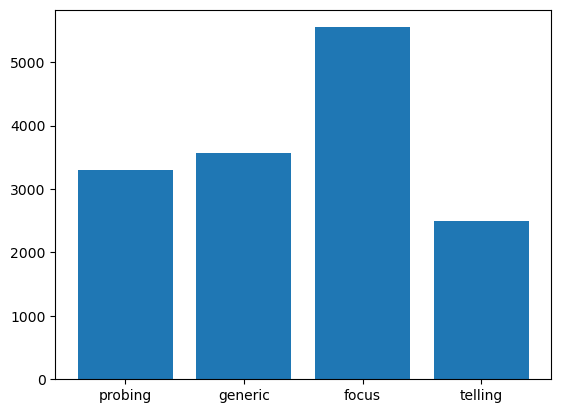

In [7]:
plt.bar(strategies.keys(), strategies.values())

In [8]:
data.head(10)

,qid,scenario,question,ground_truth,student_incorrect_solution,student_profile,teacher_described_confusion,self-correctness,self-typical-confusion,self-typical-interactions,conversation,strategies,cut_conversation
0,5000012,1,Nancy is filling an aquarium for her fish. She...,First calculate the volume of the aquarium by ...,The aquarium has a volume of 4 x 6 x 3 = 72 cu...,Steven is a 7th grade student. He has difficul...,He added a step after completing the problem.,Yes,3.0,3.0,"Teacher: (probing)Steven, If you had 4 of some...","[probing, probing, generic]","Teacher: Steven, If you had 4 of something and..."
1,5000084,2,John is very unfit and decides to work up to d...,He needs to do 15*3=45 progressions\nThat will...,"To get to 15 reps, John will take 15 - 1 = 14 ...",Stephanie is a 7th grade student. She has diff...,She became fixated on a wrong calculation and ...,No,2.0,2.0,"Teacher: (probing)Stephanie, How many days wil...","[probing, probing, probing, telling, probing, ...","Teacher: Stephanie, How many days will it take..."
2,5000982,3,James has 20 pairs of red socks and half as ma...,He has 20/2=10 black socks\nSo he has 20+10=30...,James has 20/2 = 10 pairs of black socks.\nJam...,DeAndre is a 7th grade student. He has problem...,He was technically correct.,Yes,5.0,5.0,"Teacher: (probing)DeAndre, you successfully an...","[probing, probing, probing, probing, generic]","Teacher: DeAndre, you successfully answered th..."
3,5000274,4,Jason drives past 3 convenience stores on his ...,First find the additional distance between the...,The distance between the second store and thir...,Winnie is a 7th grade student. She struggle to...,He understood it when it was broken down step ...,Yes,3.0,3.0,Teacher: (probing)What is the distance between...,"[probing, probing, probing, probing, probing, ...",Teacher: What is the distance between the firs...
4,5000797,5,Wanda walks her daughter .5 miles to school in...,She walks .5 miles to school and back 4 times ...,"Every day, Wanda walks a total of 0.5 + 0.5 = ...",Cody is a 7th grade student. He has problem wi...,He forgot she walked twice each day!,Yes,3.0,3.0,"Teacher: (probing)Cody, How far doe Wanda walk...","[probing, probing, probing, telling, probing, ...","Teacher: Cody, How far doe Wanda walk each mor..."
5,5001017,1,Chef Michel made shepherd's pie cut into 4 pie...,Chef Michel sold 52 / 4 = 13 shepherd's pies.\...,Chef Michel made 4 x 52 = 208 slices of shephe...,Alejandra is a 7th grade student. She has prob...,Student miscalculated in the first step by mul...,Yes,4.0,4.0,"Teacher: (generic)Hi Alejandra, could you plea...","[generic, probing, focus, generic]","Teacher: Hi Alejandra, could you please outlin..."
6,5000761,2,"Annie spends 2 hours a week on chess club, 8 h...",First find the total number of extracurricular...,Annie spends 2+8+3 = 13 hours a week doing ext...,Scott is a 7th grade student. He struggle to r...,Student failed to notice the calculation was f...,"Yes, but I had to reveal the answer",2.0,2.0,"Teacher: (generic)Hi Scott, Can you walk me th...","[generic, probing, probing, focus, probing, te...","Teacher: Hi Scott, Can you walk me through you..."
7,5000132,3,Forty percent of the students have elected to ...,100-40=60 percent of students are remaining.\n...,"If 40% of the students are learning from home,...",DeAndre is a 7th grade student. He struggle to...,Student duplicated division of groups,"Yes, but I had to reveal the answer",4.0,4.0,"Teacher: (generic)Hi DeAndre, could you please...","[generic, focus, focus, focus, focus, focus, f...","Teacher: Hi DeAndre, could you please explain ..."
8,5000971,4,Jack collects all his neighbors' recycling and...,First find the total amount Jack earned from t...,Let x be the number of cans Jack recycled.\nHe...,Claire is a 7th grade student. She has problem...,Student employed an overly complex approach wi...,Yes,4.0,2.0,"Teacher: (generic)Hi Claire, can you walk me t...","[generic, probing, focus, generic]","Tea

In [9]:
data.iloc[0]["conversation"]

'Teacher: (probing)Steven, If you had 4 of something and tripled that amount, how much would you have?|EOM|Steven: I would have 12 of something.|EOM|Teacher: (probing)So if Nancy triples the 18 cubic feet of water, how much would she have?|EOM|Steven: She would have 54 cubic feet of water.|EOM|Teacher: (generic)Exactly correct!'

In [10]:
PROMPT = """
The following is a fragment of a conversation between a student and a teacher:
{conversation}
"""
# PROMPT = """A tutor and a student work together to solve the following math word problem. 
# Math problem: {problem}
# The correct solution is as follows:
# {ground_truth}
# The student's solution is as follows:
# {student_solution}
# The following is a fragment of a conversation with a teacher:
# {conversation}
# """

In [11]:
from mathdial import interactivetutoring
from tqdm import tqdm

In [12]:
length_in_replics = []
length_in_teacher_replics = []

index = 0
header = ["index", "text", "label"]
new_data = []
import csv

for i, problem in data.iterrows():
    question = problem["question"]
    ground_truth_solution = problem["ground_truth"]
    incorrect_solution = problem["student_incorrect_solution"]

    replics = problem["cut_conversation"].split("|EOM|")
    uncut_replics = problem["conversation"].split("|EOM|")
    length_in_replics.append(len(replics))

    teacher_replics = 0
    for j, replic in enumerate(replics):
        if replic[:8] == "Teacher:":
            teacher_replics += 1
            a, b = uncut_replics[j].find("(") + 1, uncut_replics[j].find(")")
            if a >= 0 and b >= 0:
                label = uncut_replics[j][a:b]
                if label not in strategies:
                    print("ALARM: ", label)
                    print(uncut_replics[j])


                start = max(0, j - 3) #for shorter windows
                # text = PROMPT.format(problem=question, ground_truth=ground_truth_solution, \
                                     # student_solution=incorrect_solution, \
                                     # conversation="\n".join(replics[start:j + 1]))
                text = PROMPT.format(conversation="\n".join(replics[start:j]))
                
                new_data.append([index, text, label])
                index += 1

    length_in_teacher_replics.append(teacher_replics)


In [13]:
new_data = pd.DataFrame(new_data, columns=header)

In [14]:
new_data.to_csv('train_only_dialogue_window_1.csv', index=False)

In [15]:
import numpy as np
print("number of replics on average: ", np.array(length_in_replics).mean(), " +- ", np.array(length_in_replics).std())
print("number of teacher replics on average: ", np.array(length_in_teacher_replics).mean(), " +- ", np.array(length_in_teacher_replics).std())

number of replics on average:  12.519893899204243  +-  5.940189840231629
number of teacher replics on average:  6.591511936339523  +-  2.97726108483548


In [16]:
data["cut_conversation"][3]

'Teacher: What is the distance between the first and second stores?|EOM|Student: The distance between the first and second stores is 6 miles.|EOM|Teacher: What is the distance between the 2nd and 3rd stores?|EOM|Student: The distance between the second and third stores is 2/3 x 6 = 4 miles longer than the distance between the first two stores, so it is 6 + 4 = 10 miles.|EOM|Teacher: What is the distance between his house and the first store?|EOM|Student: The distance between his house and the first store is 4 miles.|EOM|Teacher: What is the distance between the last (3rd) store and work?|EOM|Student: The distance between the last (3rd) store and work is also 4 miles.|EOM|Teacher: What is the total of these 4 distances?|EOM|Student: The total of these 4 distances is 4 + 6 + 10 + 4 = 24 miles.|EOM|Teacher: Perfect!'